In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import os 
import re

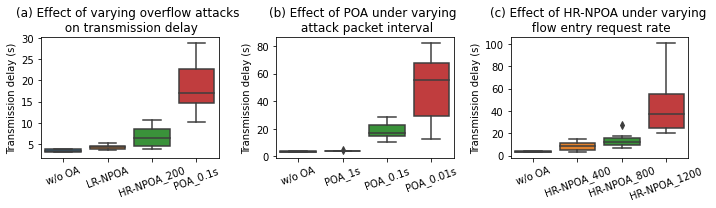

In [83]:
def draw_task_delay(file_path, save_path, columns):
    ax1_idx = [0, 1, 5, 3]
    ax2_idx = [0, 2, 3, 4]
    ax3_idx = [0, 6, 7, 8]
    result = np.loadtxt(file_path, skiprows=1)
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    
    df = pd.DataFrame(result[:, ax1_idx], columns=[columns[i] for i in ax1_idx])
    ax = sns.boxplot(data=df, ax=axes[0])
    ax.set_title('(a) Effect of varying overflow attacks \n on transmission delay')
    ax.set_ylabel('Transmission delay (s)')
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 20)
    
    df = pd.DataFrame(result[:, ax2_idx], columns=[columns[i] for i in ax2_idx])
    ax = sns.boxplot(data=df, ax=axes[1])
    ax.set_title('(b) Effect of POA under varying \n attack packet interval')
    ax.set_ylabel('Transmission delay (s)')
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 20)
    
    df = pd.DataFrame(result[:, ax3_idx], columns=[columns[i] for i in ax3_idx])
    ax = sns.boxplot(data=df, ax=axes[2])
    ax.set_title('(c) Effect of HR-NPOA under varying \n flow entry request rate')
    ax.set_ylabel('Transmission delay (s)')
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 20)
    
    fig = ax.get_figure()
    fig.tight_layout()
    fig.savefig(save_path, dpi=300)
columns = ['w/o OA', 'LR-NPOA', 'POA_1s', 'POA_0.1s', 'POA_0.01s', 'HR-NPOA_200', 'HR-NPOA_400', 'HR-NPOA_800', 'HR-NPOA_1200']
draw_task_delay('data_txt/task_delay_all.txt', 'figs/task_delay_all.png', columns)

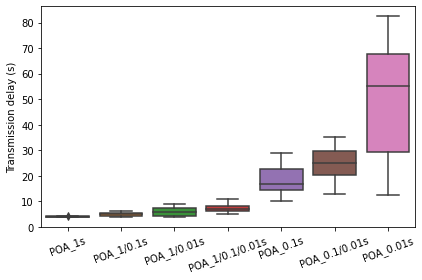

In [84]:
def draw_task_delay2(m_file_path, save_path):
    m_file_result = np.loadtxt(m_file_path, skiprows=1)
    df = pd.DataFrame(m_file_result, columns=['POA_1s', 'POA_1/0.1s', 'POA_1/0.01s', 'POA_1/0.1/0.01s', 'POA_0.1s', 'POA_0.1/0.01s', 'POA_0.01s'])
    ax = sns.boxplot(data=df)
    ax.set_ylabel('Transmission delay (s)')
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 20)
    fig = ax.get_figure()
    fig.tight_layout()
    fig.savefig(save_path, dpi=300)
draw_task_delay2('data_txt/task_delay_poa.txt', 'figs/task_delay2.png')

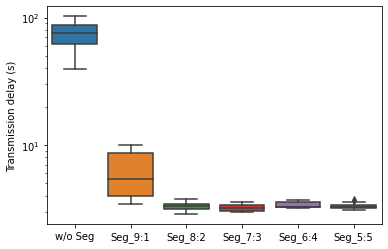

In [85]:
def seg_delay(file_path, save_path):
    results = np.loadtxt(file_path)
    df = pd.DataFrame(results, columns=['w/o Seg', 'Seg_9:1', 'Seg_8:2', 'Seg_7:3', 'Seg_6:4', 'Seg_5:5'])
    ax = sns.boxplot(data=df)
    ax.set_ylabel('Transmission delay (s)')
    ax.set_yscale('log')
    fig = ax.get_figure()
    fig.savefig(save_path, dpi=300)
    
seg_delay('data_txt/seg_delay.txt', 'figs/seg_delay.png')

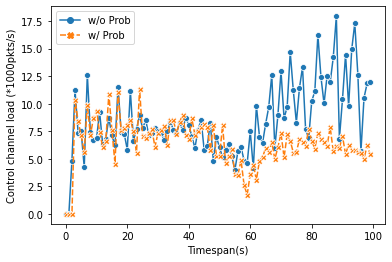

In [86]:
def draw_prob_throughput(file_path, save_path):
    results = np.loadtxt(file_path)
    results = results / 1000
    df = pd.DataFrame(results, columns=['w/o Prob', 'w/ Prob'])
    ax = sns.lineplot(data=df, markers=True)
    ax.set_xlabel('Timespan(s)')
    ax.set_ylabel('Control channel load (*1000pkts/s)')
    fig = ax.get_figure()
    fig.savefig(save_path, dpi=300)

draw_prob_throughput('data_txt/prob_throughput.txt', 'figs/prob_throughput.png')

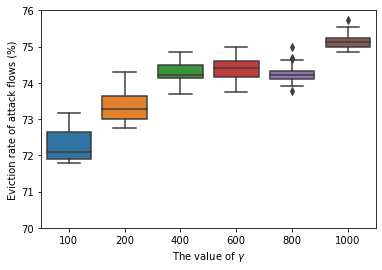

In [102]:
def draw_gamma(file_path, save_path):
    results = np.loadtxt(file_path, delimiter=',')
    results = results.T * 100
    df = pd.DataFrame(results, columns=['100', '200', '400', '600', '800', '1000'])
    ax = sns.boxplot(data=df)
    ax.set_xlabel(r'The value of $\gamma$')
    ax.set_ylabel('Eviction rate of attack flows (%)')
    ax.set_ylim(70, 76)
    fig = ax.get_figure()
    fig.savefig(save_path, dpi=300)
    
draw_gamma('data_txt/gamma.txt', 'figs/gamma.png')

In [88]:
import itertools
name_map = {
    'fifo':     'FIFO',
    'random':   'SIFT',
    'lru':      'SAIA',
    'lfu':      'LFU',
    'tg':       'TableGuard',
    'score':    'POAGuard'
}

dir_name = ['1s', '0.1s', '0.01s', '1/0.1s', '1/0.01s', '0.1/0.01s']

title_index = ['a', 'b', 'c', 'd', 'e', 'f']

def query_eviction_record(file_path):
    eviction_rates = []
    pattern = re.compile(r'evict times:\s+(\d+),\s+mal rules:\s+(\d+)')
    with open(file_path, 'r+') as fp:
        lines = fp.readlines()
    for line in lines:
        res = re.search(pattern, line)
        if res is not None:
            times, mal_entries = res.groups(0)            
            if int(times) >= 500: 
                eviction_rate = int(mal_entries) / int(times) * 100
                eviction_rates.append(eviction_rate)
    
    # fill with last item
    num_items = (1000 - 500) // 20 + 1
    if len(eviction_rates) < num_items:
        last_item = eviction_rates[-1]
        num_miss = num_items - len(eviction_rates)
        eviction_rates.extend([last_item] * num_miss)
    for name, alias in name_map.items():
        if name in file_path:
            eviction_record = {
                alias: eviction_rates
            }
    return eviction_record
                
def draw_eviction_indir(dir_path, axes, idx):
    markers = ['o', 's', '^', 'v', 'd', 'D']
    eviction_records = {}
    for file in os.listdir(dir_path):
        if not file.endswith('txt'):
            continue 
        file_path = os.path.join(dir_path, file)
        record = query_eviction_record(file_path)
        eviction_records.update(record)
    row = idx // 3
    line = idx % 3 
    # print(eviction_records)
    df = pd.DataFrame(eviction_records, index=range(500, 1020, 20), columns=list(name_map.values()))
    ax = sns.lineplot(data=df, ax=axes[row, line], markers=markers)
    ax.set_xlabel('Eviction times')
    ax.set_ylabel('Eviction rate of attack flows (%)')
    ax.set_title('({}) Packet interval {}'.format(title_index[idx], dir_name[idx]))
    ax.legend_.remove()    
    
def draw_eviction(dir_path, save_path):
    f, axes = plt.subplots(2, 3, figsize=(12, 6))
    for item in os.listdir(dir_path):
        path = os.path.join(dir_path, item)
        if os.path.isdir(path):
            name = item.replace('+', '/') if '+' in item else item
            idx = dir_name.index(name)  
            draw_eviction_indir(path, axes, idx)
    lines, labels = f.axes[-1].get_legend_handles_labels()
    f.legend(lines, labels, frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(title_index))
    f.tight_layout()
    f.savefig(save_path, dpi=300, bbox_inches='tight')

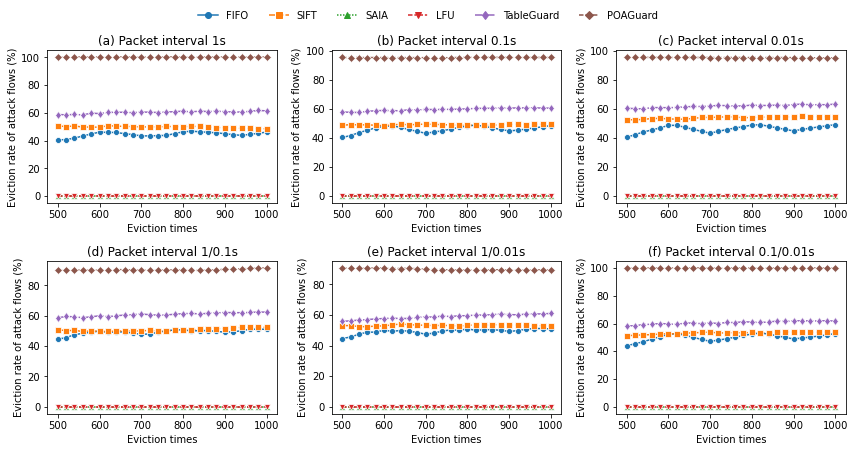

In [89]:
draw_eviction('compare_rule_replace/bg_traffic', 'figs/bg_traffic.png')

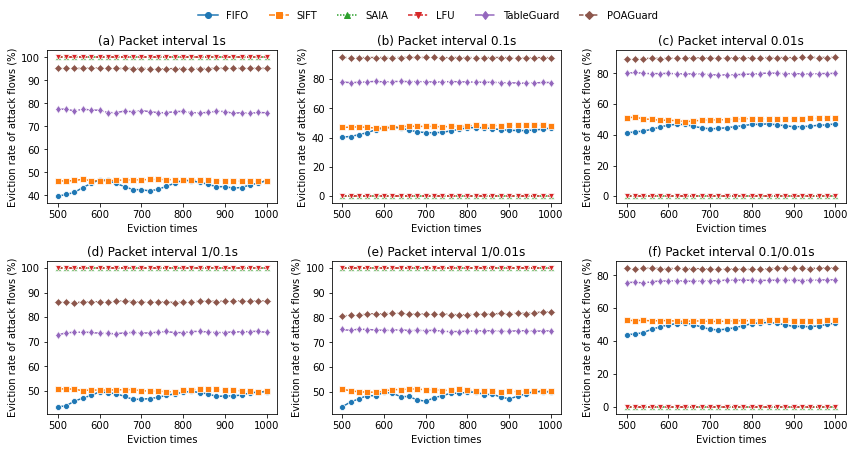

In [90]:
draw_eviction('compare_rule_replace/bg_gen', 'figs/bg_gen.png')

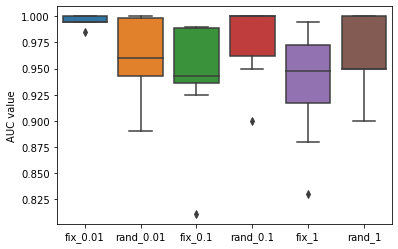

In [91]:
def auc_ival_size(file_path, save_path):
    results = np.loadtxt(file_path)
    df = pd.DataFrame(results, columns=['fix_0.01', 'rand_0.01', 'fix_0.1', 'rand_0.1', 'fix_1', 'rand_1'])
    ax = sns.boxplot(data=df)
    ax.set_ylabel('AUC value')
    fig = ax.get_figure()
    fig.savefig(save_path, dpi=300)
    
auc_ival_size('data_txt/auc_ival_size.txt', 'figs/auc_ival_size.png')

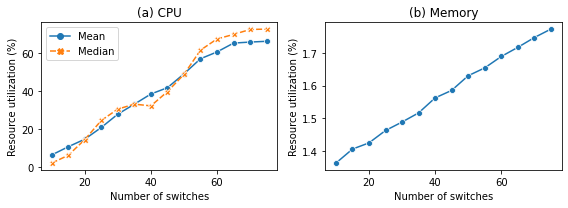

In [92]:
def draw_resource(cpu_file, mem_file, save_path):
    f, axes = plt.subplots(1, 2, figsize=(8, 3))
    results = np.loadtxt(cpu_file)
    df = pd.DataFrame(results[:,1:], columns=['Mean', 'Median'], index=results[:,0])
    ax = sns.lineplot(data=df, markers=True, ax=axes[0])
    ax.set_xlabel('Number of switches')
    ax.set_ylabel('Resource utilization (%)')
    ax.set_title('(a) CPU')
    
    results = np.loadtxt(mem_file)
    data = {
        'x': results[:,0],
        'y': results[:,1]
    }
    ax = sns.lineplot(data=data, x='x', y='y', marker='o', ax=axes[1])
    ax.set_xlabel('Number of switches')
    ax.set_ylabel('Resource utilization (%)')
    ax.set_title('(b) Memory')
    f.tight_layout()
    f.savefig(save_path, dpi=300, bbox_inches='tight')
    
draw_resource('data_txt/cpu.txt', 'data_txt/mem.txt', 'figs/resource.png')

In [93]:
def draw_detection_rate(file_path, save_path, delta_t, group_size, order):
    columns = ['30:70', '35:65', '40:60', '45:55', '50:50', '55:45', '60:40', '65:35', '70:30']
    results = np.loadtxt(file_path)
    results = np.sum(results >= delta_t, axis=0) / group_size * 100
    line_data = results
    results = results.reshape(1, -1)
    data = pd.DataFrame(results, columns=columns)
    ax = sns.barplot(data=data, color='#483D8B')
    ax.set_xlabel('Ratio of attack flows to normal flows')
    ax.set_ylabel('Detection rate (%)')
    x = np.arange(len(line_data))
    y = line_data 
    coef = np.polyfit(x, y, order)
    fit_func = np.poly1d(coef)
    sns.lineplot(x=np.arange(len(line_data)), y = fit_func(x), color='orange', marker='o', linestyle='--')
    fig = ax.get_figure()
    fig.tight_layout()
    fig.savefig(save_path, dpi=300)

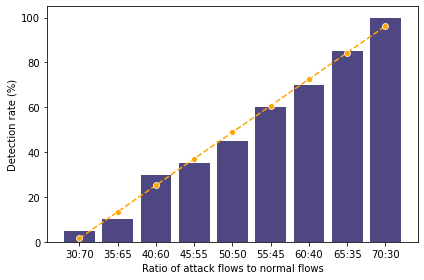

In [94]:
delta_t = 0.7
group_size = 20
order = 1
draw_detection_rate('data_txt/dt_fix_detection.txt', 'figs/dt_fix_detection.png', delta_t, group_size, order)

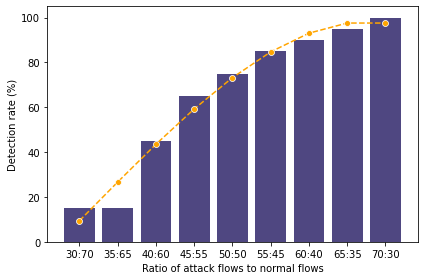

In [95]:
delta_t = 0.7
group_size = 20
order = 3
draw_detection_rate('data_txt/dt_rand_detection.txt', 'figs/dt_rand_detection.png', delta_t, group_size, order)

In [96]:
def draw_detection_rate_2(file_paths, save_path):
    columns = ['45:55', '50:50', '55:45', '60:40', '65:35', '70:30']
    index = []
    results = []
    for file_path in file_paths:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
        base_name = os.path.basename(file_path)
        token_list = base_name.split('_')
        index.append('DROPOA-' + token_list[0].upper())
        result = np.loadtxt(file_path)
        result = np.sum(result >= 0.7, axis=0) / 20 * 100
        results.append(result)
    data = pd.DataFrame(results, index=index, columns=columns)
    print(data)
    ax = sns.lineplot(data=data.T, markers=True)
    ax.set_xlabel('Ratio of attack flows to normal flows')
    ax.set_ylabel('Detection rate (%)')
    fig = ax.get_figure()
    fig.tight_layout()
    fig.savefig(save_path, dpi=300)

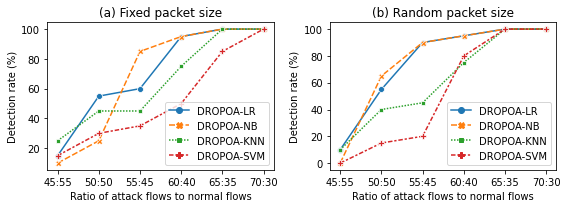

In [97]:
def draw_sub_dr(ax, file_paths, columns, title, delta_t, group_size):
    index = []
    results = []
    for file_path in file_paths:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
        base_name = os.path.basename(file_path)
        token_list = base_name.split('_')
        index.append('DROPOA-' + token_list[0].upper())
        result = np.loadtxt(file_path)
        result = np.sum(result >= delta_t, axis=0) / group_size * 100
        results.append(result)
    data = pd.DataFrame(results, index=index, columns=columns)
    ax = sns.lineplot(data=data.T, markers=True, ax=ax)
    ax.set_xlabel('Ratio of attack flows to normal flows')
    ax.set_ylabel('Detection rate (%)')
    ax.set_title(title)
    
def draw_detection_rate_2_comb(file_paths_fix, file_paths_rand, save_path, delta_t, group_size):
    columns = ['45:55', '50:50', '55:45', '60:40', '65:35', '70:30']
    title_index = [
        '(a) Fixed packet size',
        '(b) Random packet size'
    ]
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    draw_sub_dr(axes[0], file_paths_fix, columns, title_index[0], delta_t, group_size)
    draw_sub_dr(axes[1], file_paths_rand, columns, title_index[1], delta_t, group_size)
    fig.tight_layout()
    fig.savefig(save_path, dpi=300)

file_paths_fix = [
    'data_txt/lr_fix_detection.txt',
    'data_txt/nb_fix_detection.txt',
    'data_txt/knn_fix_detection.txt',
    'data_txt/svm_fix_detection.txt',
]

file_paths_rand = [
    'data_txt/lr_rand_detection.txt',
    'data_txt/nb_rand_detection.txt',
    'data_txt/knn_rand_detection.txt',
    'data_txt/svm_rand_detection.txt',
]

save_path = 'figs/other_detection.png'
draw_detection_rate_2_comb(file_paths_fix, file_paths_rand, save_path, delta_t, group_size)

In [98]:
def draw_ctrl_bw(file_path, save_path):
    bw_stat = np.loadtxt(file_path)
    bw_stat /= 1000
    index = range(30, bw_stat.shape[0])
    print(bw_stat, bw_stat.shape)
    columns = ['w/o protection', 'w/ protection']
    fig, axes = plt.subplots(3, 3, figsize=(14, 9))
    title_index = [
        '(a) Interval=1s, #Ports=1, #Flows=100',
        '(b) Interval=01s, #Ports=1, #Flows=100',
        '(c) Interval=0.01s, #Ports=1, #Flows=100',
        '(d) Interval=0.1s, #Ports=1, #Flows=200', 
        '(e) Interval=0.1s, #Ports=1, #Flows=300',
        '(f) Interval=0.1s, #Ports=1, #Flows=400',
        '(g) Interval=0.1s, #Ports=2, #Flows=300',
        '(h) Interval=0.1s, #Ports=3, #Flows=300',
        '(i) Interval=0.1s, #Ports=4, #Flows=300',
    ]
    
    for i, title in enumerate(title_index):
        data = pd.DataFrame(bw_stat[30:,i*2:i*2+2], columns=columns, index=index)
        row = i // 3
        line = i % 3 
        ax = sns.lineplot(data=data, markers=True, ax=axes[row, line])
        ax.set_xlabel('Timespan(s)')
        ax.set_ylabel('Control channel load(*1000pkt/s)')
        ax.set_title(title_index[i])
        if row == 1 and line == 1:
            ax.annotate("Timeout", xy=(0.26, 0.24), xycoords='axes fraction',
                 xytext=(0.08, 0.37), textcoords='axes fraction', fontsize=14,
                 arrowprops=dict(facecolor='red', arrowstyle="->", linewidth=2))
            ax.annotate("Migration", xy=(0.5, 0.48), xycoords='axes fraction',
                 xytext=(0.26, 0.6), textcoords='axes fraction', fontsize=14,
                 arrowprops=dict(facecolor='red', arrowstyle="->", linewidth=2))
            ax.annotate("Block", xy=(0.65, 0.28), xycoords='axes fraction',
                 xytext=(0.7, 0.12), textcoords='axes fraction', fontsize=14,
                 arrowprops=dict(facecolor='red', arrowstyle="->", linewidth=2))
            ax.annotate("Eviction", xy=(0.76, 0.6), xycoords='axes fraction',
                 xytext=(0.78, 0.72), textcoords='axes fraction', fontsize=14,
                 arrowprops=dict(facecolor='red', arrowstyle="->", linewidth=2))
            
    fig = ax.get_figure()
    fig.tight_layout()
    fig.savefig(save_path, dpi=300)
    

[[1.067 1.135 0.174 ... 0.007 0.87  0.869]
 [0.    0.    0.    ... 1.129 0.888 1.403]
 [0.    0.    0.    ... 2.043 1.505 0.887]
 ...
 [0.006 0.    0.009 ... 0.    2.082 0.   ]
 [0.021 0.007 0.042 ... 0.008 2.114 0.008]
 [0.015 0.    0.006 ... 0.003 2.183 0.003]] (100, 18)


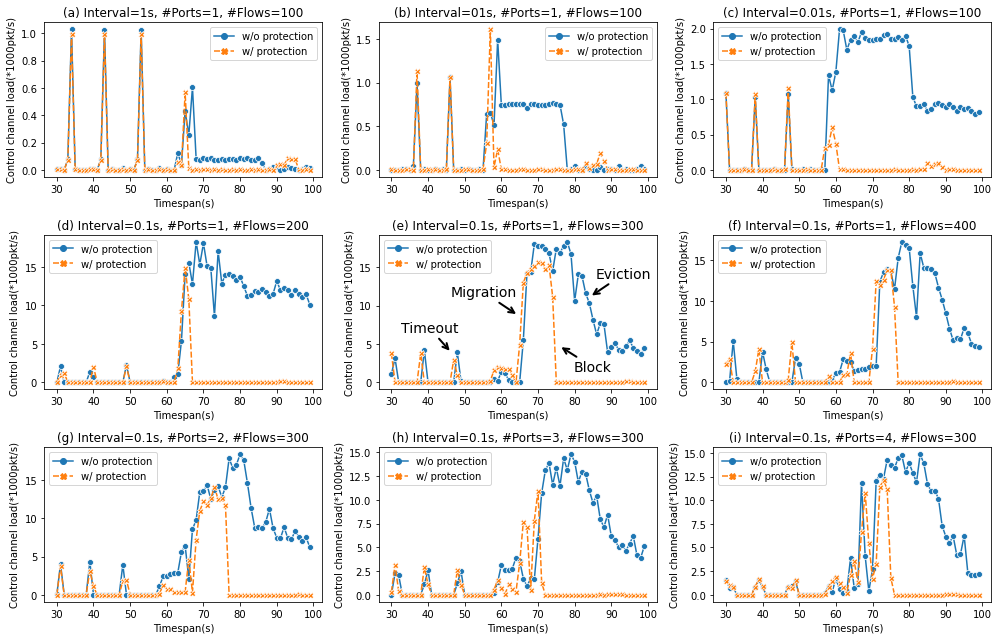

In [99]:
file_path = 'data_txt/mitigate_throughput.txt'
save_path = 'figs/mitigate_throughput.png'
draw_ctrl_bw(file_path, save_path)